# Implicit & LightFM

В данном jupyter notebook рассматриваются как использовать implicit и LightFM для построения рекомендаций

* [Load data](#load-data)
* [Validation](#validation)
* [Implicit](#implicit)
* [LightFM](#lightfm)
* [Links](#links)

In [1]:
import os
import numpy as np 
import pandas as pd 
import scipy.sparse as sp
from itertools import islice, cycle
from more_itertools import pairwise
from tqdm.auto import tqdm


os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

print('Dataset:')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Dataset:
/kaggle/input/mts-library/users.csv
/kaggle/input/mts-library/items.csv
/kaggle/input/mts-library/interactions.csv
/kaggle/input/metrics-validation-strategies-and-baselines/interactions_preprocessed.pickle
/kaggle/input/metrics-validation-strategies-and-baselines/items_preprocessed.pickle
/kaggle/input/metrics-validation-strategies-and-baselines/users_preprocessed.pickle
/kaggle/input/metrics-validation-strategies-and-baselines/__notebook__.ipynb
/kaggle/input/metrics-validation-strategies-and-baselines/custom.css
/kaggle/input/metrics-validation-strategies-and-baselines/__results__.html
/kaggle/input/metrics-validation-strategies-and-baselines/__output__.json


<a id="load-data"></a>
# Load data

Возьмем уже предобработанный данные из [metrics-validation-strategies-and-baselines](https://www.kaggle.com/sharthz23/metrics-validation-strategies-and-baselines/output)

In [2]:
df = pd.read_pickle('../input/metrics-validation-strategies-and-baselines/interactions_preprocessed.pickle')
df_users = pd.read_pickle('../input/metrics-validation-strategies-and-baselines/users_preprocessed.pickle')
df_items = pd.read_pickle('../input/metrics-validation-strategies-and-baselines/items_preprocessed.pickle')

df.shape, df_users.shape, df_items.shape

((1532998, 5), (142888, 3), (59599, 5))

In [3]:
df.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01
3,46791,83486,23,5.0,2018-01-01
4,79313,188770,88,5.0,2018-01-01


In [4]:
users_inv_mapping = dict(enumerate(df['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
len(users_mapping)

151600

In [5]:
items_inv_mapping = dict(enumerate(df['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
len(items_mapping)

59599

In [6]:
df_items['title'] = df_items['title'].str.lower()

In [7]:
item_titles = pd.Series(df_items['title'].values, index=df_items['id']).to_dict()
len(item_titles), item_titles[128115]

(59599, 'ворон-челобитчик')

In [8]:
title_items = df_items.groupby('title')['id'].agg(list)
title_items

title
# 20 восьмая                                                     [201623]
# duo                                                             [72582]
# me too. роман                                                  [171172]
# партия                                                         [224512]
#1917: человек из раньшего времени. библиотека «проекта 1917»    [230768]
                                                                   ...   
…чума на оба ваши дома!                                          [226481]
№ 12, или история одного прекрасного юноши                        [20979]
伦巴德人的故事                                                          [119226]
地球への旅                                                            [148400]
�baby blues�                                                      [98635]
Name: id, Length: 57289, dtype: object

In [9]:
title_count = title_items.map(len)
title_count.value_counts()

1     55708
2      1197
3       245
4        71
5        38
6        11
7         8
8         3
9         2
23        1
18        1
47        1
13        1
12        1
11        1
Name: id, dtype: int64

In [10]:
title_items[title_count > 1].tail()

title
яма                                              [60156, 165785]
янки из коннектикута при дворе короля артура      [14759, 56530]
японская диета                                   [168986, 74652]
яр                                                [168761, 5371]
ящик пандоры                                    [236465, 158851]
Name: id, dtype: object

In [11]:
df_items[df_items['title'] == 'ящик пандоры']

,id,title,genres,authors,year
40426,236465,ящик пандоры,"Любовно-фантастические романы,Научная фантастика",Филипп Хорват,2017
54854,158851,ящик пандоры,"Мистика,Современная зарубежная литература",Бернар Вербер,2018


In [12]:
title_items[title_count > 1].head()

title
(о переводе)                 [61213, 145263]
2084                        [177082, 281410]
451 градус по фаренгейту     [44681, 162716]
playboy 02-2018               [114405, 8599]
playboy 03-2018              [31097, 121747]
Name: id, dtype: object

In [13]:
df_items[df_items['title'] == '451 градус по фаренгейту']

,id,title,genres,authors,year
19398,44681,451 градус по фаренгейту,"Социальная фантастика,Зарубежная фантастика,На...",Рэй Брэдбери,1953
50150,162716,451 градус по фаренгейту,"Социальная фантастика,Зарубежная фантастика,На...",Рэй Брэдбери,"1951, 1953, 1967"


In [14]:
df['rating'] = np.array(df['rating'].values, dtype=np.float32)

df.loc[df['item_id'].isin([44681, 162716])].groupby('item_id').agg({
    'progress': np.size,
    'rating': ['mean'],
    'start_date': ['min', 'max'],
})

progress rating start_date           
            size   mean        min        max
item_id                                      
44681        353   4.56 2018-01-24 2019-12-20
162716        59   4.80 2018-01-25 2019-12-30

<a id="validation"></a>
# Validation

Для наших данных выбрем 7 последних дней и будем тестировать на них последовательно (1 test fold - 1 день).

Но теперь нам нужно учитывать проблему холодного старта. Это основная проблем классических метод над матрицей взаимодействий.
Поэтому напишем свой класс для разбиения исходного датафрейма на train/test

In [15]:
class TimeRangeSplit():
    """
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
    """
    def __init__(self, 
                 start_date, 
                 end_date=None, 
                 freq='D', 
                 periods=None, 
                 tz=None, 
                 normalize=False, 
                 closed=None, 
                 train_min_date=None,
                 filter_cold_users=True, 
                 filter_cold_items=True, 
                 filter_already_seen=True):
        
        self.start_date = start_date
        if end_date is None and periods is None:
            raise ValueError("Either 'end_date' or 'periods' must be non-zero, not both at the same time.")

        self.end_date = end_date
        self.freq = freq
        self.periods = periods
        self.tz = tz
        self.normalize = normalize
        self.closed = closed
        self.train_min_date = pd.to_datetime(train_min_date, errors='raise')
        self.filter_cold_users = filter_cold_users
        self.filter_cold_items = filter_cold_items
        self.filter_already_seen = filter_already_seen

        self.date_range = pd.date_range(
            start=start_date, 
            end=end_date, 
            freq=freq, 
            periods=periods, 
            tz=tz, 
            normalize=normalize, 
            closed=closed)

        self.max_n_splits = max(0, len(self.date_range) - 1)
        if self.max_n_splits == 0:
            raise ValueError("Provided parametrs set an empty date range.") 

    def split(self, 
              df, 
              user_column='user_id',
              item_column='item_id',
              datetime_column='date',
              fold_stats=False):
        df_datetime = df[datetime_column]
        if self.train_min_date is not None:
            train_min_mask = df_datetime >= self.train_min_date
        else:
            train_min_mask = df_datetime.notnull()

        date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
                                     (self.date_range <= df_datetime.max())]

        for start, end in pairwise(date_range):
            fold_info = {
                'Start date': start,
                'End date': end
            }
            train_mask = train_min_mask & (df_datetime < start)
            train_idx = df.index[train_mask]
            if fold_stats:
                fold_info['Train'] = len(train_idx)

            test_mask = (df_datetime >= start) & (df_datetime < end)
            test_idx = df.index[test_mask]
            
            if self.filter_cold_users:
                new = np.setdiff1d(
                    df.loc[test_idx, user_column].unique(), 
                    df.loc[train_idx, user_column].unique())
                new_idx = df.index[test_mask & df[user_column].isin(new)]
                test_idx = np.setdiff1d(test_idx, new_idx)
                test_mask = df.index.isin(test_idx)
                if fold_stats:
                    fold_info['New users'] = len(new)
                    fold_info['New users interactions'] = len(new_idx)

            if self.filter_cold_items:
                new = np.setdiff1d(
                    df.loc[test_idx, item_column].unique(), 
                    df.loc[train_idx, item_column].unique())
                new_idx = df.index[test_mask & df[item_column].isin(new)]
                test_idx = np.setdiff1d(test_idx, new_idx)
                test_mask = df.index.isin(test_idx)
                if fold_stats:
                    fold_info['New items'] = len(new)
                    fold_info['New items interactions'] = len(new_idx)

            if self.filter_already_seen:
                user_item = [user_column, item_column]
                train_pairs = df.loc[train_idx, user_item].set_index(user_item).index
                test_pairs = df.loc[test_idx, user_item].set_index(user_item).index
                intersection = train_pairs.intersection(test_pairs)
                test_idx = test_idx[~test_pairs.isin(intersection)]
                # test_mask = rd.df.index.isin(test_idx)
                if fold_stats:
                    fold_info['Known interactions'] = len(intersection)

            if fold_stats:
                fold_info['Test'] = len(test_idx)

            yield (train_idx, test_idx, fold_info)

    def get_n_splits(self, df, datetime_column='date'):
        df_datetime = df[datetime_column]
        if self.train_min_date is not None:
            df_datetime = df_datetime[df_datetime >= self.train_min_date]

        date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
                                     (self.date_range <= df_datetime.max())]

        return max(0, len(date_range) - 1)

In [16]:
last_date = df['start_date'].max().normalize()
folds = 7
start_date = last_date - pd.Timedelta(days=folds)
start_date, last_date

(Timestamp('2019-12-24 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [17]:
cv = TimeRangeSplit(start_date=start_date, periods=folds+1)

cv.max_n_splits, cv.get_n_splits(df, datetime_column='start_date')

(7, 7)

In [18]:
cv.date_range

DatetimeIndex(['2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='D')

In [19]:
folds_with_stats = list(cv.split(
    df, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='start_date',
    fold_stats=True
))

folds_info_with_stats = pd.DataFrame([info for _, _, info in folds_with_stats])

In [20]:
folds_info_with_stats

,Start date,End date,Train,New users,New users interactions,New items,New items interactions,Known interactions,Test
0,2019-12-24,2019-12-25,1515946,3,3,0,0,0,2045
1,2019-12-25,2019-12-26,1517994,1,1,0,0,0,2141
2,2019-12-26,2019-12-27,1520136,0,0,0,0,0,2177
3,2019-12-27,2019-12-28,1522313,0,0,0,0,0,2110
4,2019-12-28,2019-12-29,1524423,2,4,0,0,0,2205
5,2019-12-29,2019-12-30,1526632,4,4,0,0,0,2118
6,2019-12-30,2019-12-31,1528754,1,1,0,0,0,2168


In [21]:
fold_dates = [(info['Start date'], info['End date']) for _, _, info in folds_with_stats]
fold_dates

[(Timestamp('2019-12-24 00:00:00', freq='D'),
  Timestamp('2019-12-25 00:00:00', freq='D')),
 (Timestamp('2019-12-25 00:00:00', freq='D'),
  Timestamp('2019-12-26 00:00:00', freq='D')),
 (Timestamp('2019-12-26 00:00:00', freq='D'),
  Timestamp('2019-12-27 00:00:00', freq='D')),
 (Timestamp('2019-12-27 00:00:00', freq='D'),
  Timestamp('2019-12-28 00:00:00', freq='D')),
 (Timestamp('2019-12-28 00:00:00', freq='D'),
  Timestamp('2019-12-29 00:00:00', freq='D')),
 (Timestamp('2019-12-29 00:00:00', freq='D'),
  Timestamp('2019-12-30 00:00:00', freq='D')),
 (Timestamp('2019-12-30 00:00:00', freq='D'),
  Timestamp('2019-12-31 00:00:00', freq='D'))]

In [22]:
def compute_metrics(df_true, df_pred, top_N):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs['rank'] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

<a id="implicit"></a>
# Implicit

Библиотека для построения рекомендательных систем на основе датасетов с неявным таргетом.
* Репо - https://github.com/benfred/implicit
* Документация - https://implicit.readthedocs.io/en/latest/

Входные данные - разреженные матрицы (либо csr_matrix, либо coo_matrix) с типом float32/float64

In [23]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.loc[train_idx]
test = df.loc[test_idx]
train.shape, test.shape

((1515946, 5), (2045, 5))

In [24]:
info['Train'], info['Test']

(1515946, 2045)

In [25]:
def get_coo_matrix(df, 
                   user_col='user_id', 
                   item_col='item_id', 
                   weight_col=None, 
                   users_mapping=users_mapping, 
                   items_mapping=items_mapping):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            df[user_col].map(users_mapping.get), 
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [26]:
train_mat = get_coo_matrix(train).tocsr()
train_mat

<151589x59599 sparse matrix of type '<class 'numpy.float32'>'
	with 1515946 stored elements in Compressed Sparse Row format>

## Item-to-item модели

**Векорное представление для объекта** - весь столбец из матрицы взаимодействий (user_item) матрица

**Процесс построения рекомендаций** - поиск похожих объектов (по косинусной близости) для всех объектов, с которыми пользователь уже взаимодействовал и выдача топа из этого списка

**Пространство для тюнинга** - взвешние на уровне таблицы, взвешивание элементов матрицы (на уровне моделей), кол-во соседей `K`

In [27]:
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender

Этим модели для Item-to-item подхода ожидают на вход матрицу в ориентации item_user, поэтому в `fit` передаем `train_mat.T`

In [28]:
cosine_model = CosineRecommender(K=10)
cosine_model.fit(train_mat.T) # 

In [29]:
top_N = 10
user_id = test['user_id'].iloc[0]
row_id = users_mapping[user_id]
print(f'Рекомендации для пользователя {user_id}, номер строки - {row_id}')

Рекомендации для пользователя 139942, номер строки - 10346


Параметр `K` влияет на максимальную выдачу топа, поэтому `N` для таких моделей желательно указывать меньше `K`

In [30]:
recs = cosine_model.recommend(row_id, train_mat, N=top_N, filter_already_liked_items=True)
recs = pd.DataFrame(recs, columns=['col_id', 'similarity'])
recs

,col_id,similarity
0,4341,0.297014
1,7353,0.220847
2,36593,0.215622
3,3802,0.188025
4,51215,0.145095
5,49085,0.128586
6,37852,0.102340
7,7873,0.101929
8,46769,0.100504
9,56270,0.100504


In [31]:
recs['item_id'] = recs['col_id'].map(items_inv_mapping.get)
recs['title'] = recs['item_id'].map(item_titles.get)
recs

,col_id,similarity,item_id,title
0,4341,0.297014,193358,#охотник на волков
1,7353,0.220847,125586,меч предназначения
2,36593,0.215622,203882,#имя для лис
3,3802,0.188025,90986,кровь эльфов
4,51215,0.145095,146180,крещение руси
5,49085,0.128586,264849,сплав закона
6,37852,0.102340,238155,владычица озера
7,7873,0.101929,7094,крещение огнем
8,46769,0.100504,240226,отпущение без грехов
9,56270,0.100504,1728,«злой город»


In [32]:
def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.recommend(user_id, 
                               train_matrix, 
                               N=N, 
                               filter_already_liked_items=True)
        return [item_inv_mapping[item] for item, _ in recs]
    return _recs_mapper

In [33]:
mapper = generate_implicit_recs_mapper(cosine_model, train_mat, top_N, users_mapping, items_inv_mapping)
mapper

<function __main__.generate_implicit_recs_mapper.<locals>._recs_mapper(user)>

In [34]:
%time
recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})
recs['item_id'] = recs['user_id'].map(mapper)
recs.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


,user_id,item_id
0,139942,"[193358, 125586, 203882, 90986, 146180, 264849..."
1,136607,"[250158, 121182, 141120, 242513, 287501, 18072..."
2,142287,"[290518, 118497, 98037, 229832, 84366, 257330,..."
3,114933,"[136034, 251645, 96466, 152566, 208621, 109493..."
4,32926,"[121606, 201300, 145840, 113767, 311587, 28831..."


In [35]:
recs = recs.explode('item_id')
recs['rank'] = recs.groupby('user_id').cumcount() + 1
recs.head(top_N + 2)

,user_id,item_id,rank
0,139942,193358,1
0,139942,125586,2
0,139942,203882,3
0,139942,90986,4
0,139942,146180,5
0,139942,264849,6
0,139942,238155,7
0,139942,7094,8
0,139942,240226,9
0,139942,1728,10


In [36]:
metrics = compute_metrics(test, recs, top_N)
metrics

Precision@1     0.011628
Recall@1        0.010200
Precision@2     0.010098
Recall@2        0.018054
Precision@3     0.009384
Recall@3        0.024057
Precision@4     0.007956
Recall@4        0.026811
Precision@5     0.007222
Recall@5        0.030075
Precision@6     0.006222
Recall@6        0.031299
Precision@7     0.005595
Recall@7        0.032421
Precision@8     0.005661
Recall@8        0.036589
Precision@9     0.005168
Recall@9        0.037099
Precision@10    0.004896
Recall@10       0.039139
MAP@10          0.018753
MRR             0.021653
dtype: float64

Как видно, на матрице, заполненной единицами, CosineRecommender с K=10 уже дает метрики немного лучше, чем просто учет популярного

In [37]:
%%time
validation_results = pd.DataFrame()

for train_idx, test_idx, info in folds_with_stats:
    print(f"test range - from {info['Start date']} to {info['End date']}")
    train = df.loc[train_idx]
    test = df.loc[test_idx]
    print(f'train shape - {train.shape}, test shape - {test.shape}')
    
    train_mat = get_coo_matrix(train).tocsr()
    
    cosine_model = CosineRecommender(K=10)
    cosine_model.fit(train_mat.T) # 
    
    mapper = generate_implicit_recs_mapper(cosine_model, train_mat, top_N, users_mapping, items_inv_mapping)
    
    recs = pd.DataFrame({
        'user_id': test['user_id'].unique()
    })
    recs['item_id'] = recs['user_id'].map(mapper)
    recs = recs.explode('item_id')
    recs['rank'] = recs.groupby('user_id').cumcount() + 1
    fold_result = compute_metrics(test, recs, top_N)
    fold_result.at['Date'] = info['Start date']
    fold_result.at['argv'] = 'K=10'
    fold_result.at['Model'] = 'cosine model'
    
    validation_results = validation_results.append(fold_result, ignore_index=True)

test range - from 2019-12-24 00:00:00 to 2019-12-25 00:00:00
train shape - (1515946, 5), test shape - (2045, 5)



test range - from 2019-12-25 00:00:00 to 2019-12-26 00:00:00
train shape - (1517994, 5), test shape - (2141, 5)



test range - from 2019-12-26 00:00:00 to 2019-12-27 00:00:00
train shape - (1520136, 5), test shape - (2177, 5)



test range - from 2019-12-27 00:00:00 to 2019-12-28 00:00:00
train shape - (1522313, 5), test shape - (2110, 5)



test range - from 2019-12-28 00:00:00 to 2019-12-29 00:00:00
train shape - (1524423, 5), test shape - (2205, 5)



test range - from 2019-12-29 00:00:00 to 2019-12-30 00:00:00
train shape - (1526632, 5), test shape - (2118, 5)



test range - from 2019-12-30 00:00:00 to 2019-12-31 00:00:00
train shape - (1528754, 5), test shape - (2168, 5)



CPU times: user 41.6 s, sys: 3.67 s, total: 45.3 s
Wall time: 26.2 s


In [38]:
validation_results

,Date,MAP@10,MRR,Model,Precision@1,Precision@10,Precision@2,Precision@3,Precision@4,Precision@5,...,Recall@10,Recall@2,Recall@3,Recall@4,Recall@5,Recall@6,Recall@7,Recall@8,Recall@9,argv
0,2019-12-24,0.018753,0.021653,cosine model,0.011628,0.004896,0.010098,0.009384,0.007956,0.007222,...,0.039139,0.018054,0.024057,0.026811,0.030075,0.031299,0.032421,0.036589,0.037099,K=10
1,2019-12-25,0.014539,0.016503,cosine model,0.009009,0.004110,0.008727,0.007132,0.005912,0.005405,...,0.033936,0.013462,0.016570,0.018541,0.021638,0.024172,0.027742,0.031121,0.032528,K=10
2,2019-12-26,0.011097,0.012303,cosine model,0.006959,0.002944,0.006692,0.004996,0.004416,0.004283,...,0.023708,0.010974,0.012134,0.013638,0.016672,0.018622,0.019693,0.022102,0.023172,K=10
3,2019-12-27,0.013305,0.014925,cosine model,0.009945,0.002873,0.007182,0.006262,0.005387,0.004530,...,0.023812,0.012560,0.015893,0.017937,0.018232,0.020442,0.020994,0.021602,0.022707,K=10
4,2019-12-28,0.010155,0.011132,cosine model,0.006051,0.002915,0.005226,0.003850,0.003850,0.003300,...,0.023710,0.009213,0.010314,0.013751,0.014439,0.016806,0.018181,0.019556,0.021756,K=10
5,2019-12-29,0.014726,0.016824,cosine model,0.009737,0.003952,0.007732,0.006873,0.005871,0.005155,...,0.031819,0.012791,0.016705,0.018423,0.020332,0.023260,0.025837,0.027460,0.028096,K=10
6,2019-12-30,0.013807,0.014917,cosine model,0.010259,0.003240,0.006479,0.005220,0.004860,0.004320,...,0.028123,0.011519,0.013949,0.016964,0.018853,0.022093,0.023083,0.023893,0.026773,K=10


In [39]:
validation_results.agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

,MRR,MAP@10,Recall@10
mean,0.015466,0.013769,0.029178
std,0.003430,0.002792,0.006035
min,0.011132,0.010155,0.023708
max,0.021653,0.018753,0.039139


In [40]:
for model_class in [BM25Recommender, TFIDFRecommender]:
    for train_idx, test_idx, info in folds_with_stats:
        print(f"test range - from {info['Start date']} to {info['End date']}")
        train = df.loc[train_idx]
        test = df.loc[test_idx]
        print(f'train shape - {train.shape}, test shape - {test.shape}')
        
        train_mat = get_coo_matrix(train).tocsr()
        
        model = model_class(K=10)
        model.fit(train_mat.T, show_progress=False) 

        mapper = generate_implicit_recs_mapper(model, train_mat, top_N, users_mapping, items_inv_mapping)

        recs = pd.DataFrame({
            'user_id': test['user_id'].unique()
        })
        recs['item_id'] = recs['user_id'].map(mapper)
        recs = recs.explode('item_id')
        recs['rank'] = recs.groupby('user_id').cumcount() + 1
        fold_result = compute_metrics(test, recs, top_N)
        fold_result.at['Date'] = info['Start date']
        fold_result.at['argv'] = 'K=10'
        fold_result.at['Model'] = model.__class__.__name__

        validation_results = validation_results.append(fold_result, ignore_index=True)

test range - from 2019-12-24 00:00:00 to 2019-12-25 00:00:00
train shape - (1515946, 5), test shape - (2045, 5)
test range - from 2019-12-25 00:00:00 to 2019-12-26 00:00:00
train shape - (1517994, 5), test shape - (2141, 5)
test range - from 2019-12-26 00:00:00 to 2019-12-27 00:00:00
train shape - (1520136, 5), test shape - (2177, 5)
test range - from 2019-12-27 00:00:00 to 2019-12-28 00:00:00
train shape - (1522313, 5), test shape - (2110, 5)
test range - from 2019-12-28 00:00:00 to 2019-12-29 00:00:00
train shape - (1524423, 5), test shape - (2205, 5)
test range - from 2019-12-29 00:00:00 to 2019-12-30 00:00:00
train shape - (1526632, 5), test shape - (2118, 5)
test range - from 2019-12-30 00:00:00 to 2019-12-31 00:00:00
train shape - (1528754, 5), test shape - (2168, 5)
test range - from 2019-12-24 00:00:00 to 2019-12-25 00:00:00
train shape - (1515946, 5), test shape - (2045, 5)
test range - from 2019-12-25 00:00:00 to 2019-12-26 00:00:00
train shape - (1517994, 5), test shape - (2

In [41]:
validation_results

,Date,MAP@10,MRR,Model,Precision@1,Precision@10,Precision@2,Precision@3,Precision@4,Precision@5,...,Recall@10,Recall@2,Recall@3,Recall@4,Recall@5,Recall@6,Recall@7,Recall@8,Recall@9,argv
0,2019-12-24,0.018753,0.021653,cosine model,0.011628,0.004896,0.010098,0.009384,0.007956,0.007222,...,0.039139,0.018054,0.024057,0.026811,0.030075,0.031299,0.032421,0.036589,0.037099,K=10
1,2019-12-25,0.014539,0.016503,cosine model,0.009009,0.004110,0.008727,0.007132,0.005912,0.005405,...,0.033936,0.013462,0.016570,0.018541,0.021638,0.024172,0.027742,0.031121,0.032528,K=10
2,2019-12-26,0.011097,0.012303,cosine model,0.006959,0.002944,0.006692,0.004996,0.004416,0.004283,...,0.023708,0.010974,0.012134,0.013638,0.016672,0.018622,0.019693,0.022102,0.023172,K=10
3,2019-12-27,0.013305,0.014925,cosine model,0.009945,0.002873,0.007182,0.006262,0.005387,0.004530,...,0.023812,0.012560,0.015893,0.017937,0.018232,0.020442,0.020994,0.021602,0.022707,K=10
4,2019-12-28,0.010155,0.011132,cosine model,0.006051,0.002915,0.005226,0.003850,0.003850,0.003300,...,0.023710,0.009213,0.010314,0.013751,0.014439,0.016806,0.018181,0.019556,0.021756,K=10
5,2019-12-29,0.014726,0.016824,cosine model,0.009737,0.003952,0.007732,0.006873,0.005871,0.005155,...,0.031819,0.012791,0.016705,0.018423,0.020332,0.023260,0.025837,0.027460,0.028096,K=10
6,2019-12-30,0.013807,0.014917,cosine model,0.010259,0.003240,0.006479,0.005220,0.004860,0.004320,...,0.028123,0.011519,0.013949,0.016964,0.018853,0.022093,0.023083,0.023893,0.026773,K=10
7,2019-12-24,0.018977,0.022296,BM25Recommender,0.014076,0.004774,0.010098,0.009384,0.007803,0.007222,...,0.037113,0.017136,0.023460,0.025806,0.029682,0.031620,0.032538,0.032931,0.035379,K=10
8,2019-12-25,0.014419,0.015624,BM25Recommender,0.009009,0.003716,0.007038,0.006569,0.006334,0.005518,...,0.031151,0.011761,0.016277,0.020031,0.022283,0.023972,0.026788,0.027914,0.028899,K=10
9,2019-12-26,0.013319,0.015631,BM25Recommender,0.009101,0.003480,0.008833,0.006602,0.005621,0.005032,...,0.028067,0.013804,0.015499,0.017105,0.019514,0.022191,0.023338,0.024676,0.025925,K=10


In [42]:
validation_results.groupby(['Model', 'argv']).agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

MRR                                  MAP@10  \
                           mean       std       min       max      mean   
Model            argv                                                     
BM25Recommender  K=10  0.015759  0.003429  0.010862  0.022296  0.013908   
TFIDFRecommender K=10  0.015844  0.003811  0.011226  0.023071  0.014056   
cosine model     K=10  0.015466  0.003430  0.011132  0.021653  0.013769   

                                                    Recall@10            \
                            std       min       max      mean       std   
Model            argv                                                     
BM25Recommender  K=10  0.002880  0.009243  0.018977  0.029273  0.004234   
TFIDFRecommender K=10  0.003195  0.010224  0.020040  0.029277  0.005309   
cosine model     K=10  0.002792  0.010155  0.018753  0.029178  0.006035   

                                           
                            min       max  
Model            argv                      
BM25Recommender  K=10  0.024603  0.037113  
TFIDFRecommender K=10  0.023529  0.037929  
cosine model     K=10  0.023708  0.039139

In [43]:
model

In [44]:
model.similarity

<59599x59599 sparse matrix of type '<class 'numpy.float64'>'
	with 595990 stored elements in Compressed Sparse Row format>

In [45]:
model.similar_items(7789, N=10)

[(7789, 0.9999999999999997),
 (2354, 0.08739371081396644),
 (2369, 0.08324974641072473),
 (26607, 0.08070989029073747),
 (51053, 0.07998056290930719),
 (57349, 0.07708399087660989),
 (38100, 0.07580568971259077),
 (35713, 0.07271956924786306),
 (39208, 0.07009032705635235),
 (46434, 0.06839100852746778)]

In [46]:
def get_similar_books(title, model, N=10, idx=0, 
                      title_items=title_items, item_titles=item_titles, items_mapping=items_mapping, items_inv_mapping=items_inv_mapping):
    item_ids = title_items.at[title]
    if len(item_ids) == 1:
        item_id = item_ids[0]
    else:
        item_id = item_ids[idx]
    
    col_id = items_mapping[item_id]
    similar = model.similar_items(col_id, N=N)
    similar = pd.DataFrame(similar, columns=['col_id', 'similarity'])
    similar['item_id'] = similar['col_id'].map(items_inv_mapping.get)
    similar['title'] = similar['item_id'].map(item_titles.get)
    return similar

In [47]:
get_similar_books('мастер и маргарита', model)

,col_id,similarity,item_id,title
0,1466,1.000000,60193,мастер и маргарита
1,4441,0.085901,252228,мастер и маргарита (иллюстрированное издание)
2,11689,0.057461,283431,мастер и маргарита краткий пересказ произведен...
3,3874,0.038287,106146,без имени
4,28450,0.034565,129959,белая гвардия. мастер и маргарита (иллюстриров...
5,42072,0.033712,229856,"булгаков и «маргарита», или история несчастной..."
6,47663,0.033223,284757,стори 11-2015
7,8220,0.032520,214968,драгоценная плоть
8,58432,0.031764,303726,ничего не возьму с собой
9,53017,0.031390,9282,идущий на север. долина башен


In [48]:
get_similar_books('пикник на обочине', model)

,col_id,similarity,item_id,title
0,23397,1.000000,235407,пикник на обочине
1,8237,0.081634,208935,понедельник начинается в субботу
2,13604,0.075878,86572,град обреченный
3,46038,0.053919,85633,жук в муравейнике
4,9537,0.048289,128823,обитаемый остров
5,11830,0.046667,85653,волны гасят ветер
6,23062,0.043113,138608,сталкер
7,40889,0.038316,287365,большой прикол. анекдоты 31-2016
8,39976,0.035602,94631,трудно быть богом
9,1992,0.031722,35265,записки юного врача


## AlternatingLeastSquares

**Векорное представление** - на основе разложения матрицы взамиодействий (с весами) в произведение двух матриц. 
Одна матрица размерности `[users x factors]` содержит векторные представления всех пользователей,
другая матрица `[items x factors]` для объектов

**Процесс построения рекомендаций** - для конкретного пользователя ищутся такие объекты, что скалярное произведение их векторов максимально.

**Пространство для тюнинга** 
* взвешивание на уровне таблицы
* `factors` - размерность итоговых векторов (обычно степени 2-ки, от 16 до 256)
* `iterations` - кол-во итераций (от 10 до 100)
* `regularization` - регуляризация векторов (степени 10-ки, от 0.0001 до 1)

Есть возможность использовать GPU через `use_gpu=True` и ApproximateNearestNeighbors (на уровне модели)

In [49]:
from implicit.als import AlternatingLeastSquares

In [50]:
for train_idx, test_idx, info in folds_with_stats:
    print(f"test range - from {info['Start date']} to {info['End date']}")
    train = df.loc[train_idx]
    test = df.loc[test_idx]
    print(f'train shape - {train.shape}, test shape - {test.shape}')
    
    train_mat = get_coo_matrix(train).tocsr()
    
    als_model = AlternatingLeastSquares(factors=32, iterations=30, num_threads=4)
    als_model.fit(train_mat.T) 
    
    mapper = generate_implicit_recs_mapper(als_model, train_mat, top_N, users_mapping, items_inv_mapping)
    
    recs = pd.DataFrame({
        'user_id': test['user_id'].unique()
    })
    recs['item_id'] = recs['user_id'].map(mapper)
    recs = recs.explode('item_id')
    recs['rank'] = recs.groupby('user_id').cumcount() + 1
    metrics = compute_metrics(test, recs, top_N)
    
    fold_result = pd.Series(metrics)
    fold_result.at['Date'] = info['Start date']
    fold_result.at['argv'] = 'factors=32 iterations=30'
    fold_result.at['Model'] = als_model.__class__.__name__
    
    validation_results = validation_results.append(fold_result, ignore_index=True)

test range - from 2019-12-24 00:00:00 to 2019-12-25 00:00:00
train shape - (1515946, 5), test shape - (2045, 5)



test range - from 2019-12-25 00:00:00 to 2019-12-26 00:00:00
train shape - (1517994, 5), test shape - (2141, 5)



test range - from 2019-12-26 00:00:00 to 2019-12-27 00:00:00
train shape - (1520136, 5), test shape - (2177, 5)



test range - from 2019-12-27 00:00:00 to 2019-12-28 00:00:00
train shape - (1522313, 5), test shape - (2110, 5)



test range - from 2019-12-28 00:00:00 to 2019-12-29 00:00:00
train shape - (1524423, 5), test shape - (2205, 5)



test range - from 2019-12-29 00:00:00 to 2019-12-30 00:00:00
train shape - (1526632, 5), test shape - (2118, 5)



test range - from 2019-12-30 00:00:00 to 2019-12-31 00:00:00
train shape - (1528754, 5), test shape - (2168, 5)


In [51]:
validation_results.groupby(['Model', 'argv']).agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

MRR            \
                                                      mean       std   
Model                   argv                                           
AlternatingLeastSquares factors=32 iterations=30  0.005206  0.001122   
BM25Recommender         K=10                      0.015759  0.003429   
TFIDFRecommender        K=10                      0.015844  0.003811   
cosine model            K=10                      0.015466  0.003430   

                                                                      \
                                                       min       max   
Model                   argv                                           
AlternatingLeastSquares factors=32 iterations=30  0.003465  0.007109   
BM25Recommender         K=10                      0.010862  0.022296   
TFIDFRecommender        K=10                      0.011226  0.023071   
cosine model            K=10                      0.011132  0.021653   

                                                    MAP@10            \
                                                      mean       std   
Model                   argv                                           
AlternatingLeastSquares factors=32 iterations=30  0.004277  0.001080   
BM25Recommender         K=10                      0.013908  0.002880   
TFIDFRecommender        K=10                      0.014056  0.003195   
cosine model            K=10                      0.013769  0.002792   

                                                                      \
                                                       min       max   
Model                   argv                                           
AlternatingLeastSquares factors=32 iterations=30  0.002888  0.005930   
BM25Recommender         K=10                      0.009243  0.018977   
TFIDFRecommender        K=10                      0.010224  0.020040   
cosine model            K=10                      0.010155  0.018753   

                                                 Recall@10            \
                                                      mean       std   
Model                   argv                                           
AlternatingLeastSquares factors=32 iterations=30  0.011298  0.001814   
BM25Recommender         K=10                      0.029273  0.004234   
TFIDFRecommender        K=10                      0.029277  0.005309   
cosine model            K=10                      0.029178  0.006035   

                                                                      
                                                       min       max  
Model                   argv                                          
AlternatingLeastSquares factors=32 iterations=30  0.009069  0.014591  
BM25Recommender         K=10                      0.024603  0.037113  
TFIDFRecommender        K=10                      0.023529  0.037929  
cosine model            K=10                      0.023708  0.039139

In [52]:
als_model.user_factors.shape, als_model.item_factors.shape

((151599, 32), (59599, 32))

In [53]:
get_similar_books('мастер и маргарита', als_model)

,col_id,similarity,item_id,title
0,1466,1.000000,60193,мастер и маргарита
1,20491,0.965694,122087,граф монте-кристо
2,9833,0.962352,292402,тарас бульба
3,2740,0.961435,126875,идиот
4,12794,0.958931,253765,война и мир. том 1
5,736,0.958333,82566,превращение
6,4441,0.958249,252228,мастер и маргарита (иллюстрированное издание)
7,26581,0.957401,183142,собачье сердце
8,1934,0.952757,218707,маленький принц
9,12460,0.950674,200356,игрок


In [54]:
get_similar_books('пикник на обочине', als_model)

,col_id,similarity,item_id,title
0,23397,1.000000,235407,пикник на обочине
1,30137,0.934646,186043,вечера на хуторе близ диканьки
2,39976,0.932771,94631,трудно быть богом
3,13530,0.930742,13395,террор
4,2772,0.923324,139440,аврора
5,1925,0.921072,78340,большая телега
6,8237,0.919252,208935,понедельник начинается в субботу
7,2797,0.917212,107656,пять недель на воздушном шаре
8,5720,0.916713,159436,роковые яйца
9,4909,0.916253,151190,история государства российского. том 2. от вел...


In [55]:
similar_users = als_model.similar_users(0, N=5)
similar_users

[(0, 1.0),
 (50230, 0.977332),
 (132029, 0.9770293),
 (31360, 0.97594684),
 (58022, 0.97385883)]

In [56]:
similar_users = als_model.similar_users(144, N=5)
for (uid, sim) in similar_users:
    user_id = users_inv_mapping[uid]
    print(f'User ID - {user_id} ({sim:.4f})')
    user_mask = train['user_id'] == user_id
    user_items = train.loc[user_mask, 'item_id'].map(item_titles.get)
    print(user_items.to_string(index=False))

User ID - 138614 (1.0000)
   осторожно, триггеры (сборник)
           тайна «железной дамы»
           ваз. ремонт двигателя
 мата хари. танец любви и смерти
               бегущая по волнам
               королевский квест
            коготь велоцираптора
User ID - 133127 (0.9491)
                 создание интернет-магазина
     таинственный дом в туманном поднебесье
 коммерсантъ (понедельник-пятница) 165-2019
                          бегущая по волнам
                   почти умер, чтобы выжить
                  сказка, повесть и рассказ
                   дыра. путь на ту сторону
                          дневник марафонца
   лайфхаки по управлению личными финансами
User ID - 144984 (0.9202)
        роза для палача
        дама с собачкой
             палата № 6
           черная весна
               машенька
                о любви
                  гроза
                     мы
   все мои враги мертвы
 валлия. обретение дара
            остров крым
User ID - 108720 (0.9165)
     

<a id="lightfm"></a>
# LightFM

Библиотека для построения рекомендательных систем с помощью матричных разложений и фичей
* Репо - https://github.com/lyst/lightfm
* Документация - https://making.lyst.com/lightfm/docs/home.html

Входные данные - разреженные матрицы (либо csr_matrix, либо coo_matrix)
Модель одна, варируются только loss functions. Также есть вспомогательный класс lightfm.data.Dataset для построения как матрицы взаимодействий, так и матриц фичей

**Основая идея** - построить векторные представления для каждой фичи по пользователю и объекту. Если фичей нет, то просто используем индикаторные фичи (единичная матрица по пользователям и объектам соответственно)
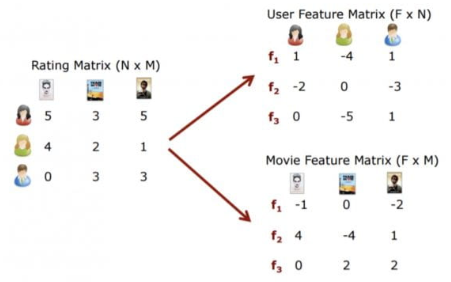
[image source](https://sites.northwestern.edu/msia/2019/04/24/personalized-restaurant-recommender-system-using-hybrid-approach/#:~:text=LightFM%20incorporates%20matrix%20factorization%20model,retain%20the%20original%20interaction%20matrix.&text=The%20latent%20embeddings%20could%20capture,items%2C%20which%20represent%20their%20tastes.)

**Векорное представление** - векторы для пользователя и объекта получают суммирование векторов их фичей.

**Процесс построения рекомендаций** - для конкретного пользователя ищутся такие объекты, что скалярное произведение их векторов максимально.

**Пространство для тюнинга** 
* взвешивание на уровне таблицы
* `loss` - обучение функции ранжирования.
    * `logistic`
    * `bpr`
    * `warp`
    * `warp-kos`
* `no_components` - размерность итоговых векторов (обычно степени 2-ки, от 16 до 256)
* `learning_rate` - "скорость" обучения
* `item_alpha`/`user_alpha` - регуляризация (степени 10-ки, от 0.0001 до 1)

In [57]:
from lightfm.data import Dataset
from lightfm import LightFM

In [58]:
dataset = Dataset()

In [59]:
dataset.fit(df['user_id'].unique(), df['item_id'].unique())

In [60]:
df_users['age'] = df_users['age'].cat.add_categories('age_unknown')
df_users['age'] = df_users['age'].fillna('age_unknown')
age_features = df_users['age'].unique()
age_features

['45_54', '18_24', '65_inf', '35_44', '55_64', '25_34', 'age_unknown']
Categories (7, object): ['45_54', '18_24', '65_inf', '35_44', '55_64', '25_34', 'age_unknown']

In [61]:
df_users['sex'] = np.array(df_users['sex'].astype(str))
df_users['sex'] = df_users['sex'].fillna('age_unknown')
sex_features = df_users['sex'].unique()
sex_features

array(['nan', '0.0', '1.0'], dtype=object)

In [62]:
users_features = np.append(age_features, sex_features)
users_features

array(['45_54', '18_24', '65_inf', '35_44', '55_64', '25_34',
       'age_unknown', 'nan', '0.0', '1.0'], dtype=object)

In [63]:
dataset.fit_partial(user_features=users_features)

In [64]:
df_items['genres'] = df_items['genres'].cat.add_categories('genre_unknown')
df_items['genres'] = df_items['genres'].fillna('genre_unknown')
genres = list(df_items['genres'].str.split(',').explode().unique())
len(genres)

641

In [65]:
dataset.fit_partial(item_features=genres)

In [66]:
num_users, num_items = dataset.interactions_shape()
num_users, num_items

(151600, 59599)

In [67]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('users_mapping len - ', len(lightfm_mapping['users_mapping']))
print('user_features_mapping len - ', len(lightfm_mapping['user_features_mapping']))
print('items_mapping len - ', len(lightfm_mapping['items_mapping']))
print('Users item_features_mapping len - ', len(lightfm_mapping['item_features_mapping']))

users_mapping len -  151600
user_features_mapping len -  151610
items_mapping len -  59599
Users item_features_mapping len -  60240


In [68]:
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [69]:
num_user_features = dataset.user_features_shape()
num_show_features = dataset.item_features_shape()
print('Num user features: {} -> {}\nnum item features: {} -> {}.'.format(
    num_user_features[1] - num_users, num_user_features[1], 
    num_show_features[1] - num_items, num_show_features[1]))

Num user features: 10 -> 151610
num item features: 641 -> 60240.


Как собрать теперь наши матрицы. 
* Для интеракций нужен итератор на 
    * `[(user_id1, item_id1), (user_id2, item_id2), ...]`  
    * `[(user_id1, item_id1, weight), (user_id2, item_id2, weight), ...]`
* Для фичей нужен итератор на 
    * `[(id, [feature1, feature2, ...]), (id, [feature1, feature2, ...]), ...]`  
    * `[(id, {feature1: weight}), (id, {feature1: weight}), ...]`

In [70]:
def df_to_tuple_iterator(df):
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [71]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.loc[train_idx]
test = df.loc[test_idx]

In [72]:
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(train[['user_id', 'item_id']]))
train_mat

<151600x59599 sparse matrix of type '<class 'numpy.int32'>'
	with 1515946 stored elements in COOrdinate format>

In [73]:
train_mat_weights

<151600x59599 sparse matrix of type '<class 'numpy.float32'>'
	with 1515946 stored elements in COOrdinate format>

In [74]:
df_users['features'] = df_users[['age', 'sex']].astype(str).apply(lambda x: list(x), axis=1)
df_users.head()

,user_id,age,sex,features
0,1,45_54,nan,"[45_54, nan]"
1,2,18_24,0.0,"[18_24, 0.0]"
2,3,65_inf,0.0,"[65_inf, 0.0]"
3,4,18_24,0.0,"[18_24, 0.0]"
4,5,35_44,0.0,"[35_44, 0.0]"


In [75]:
known_users_filter = df_users['user_id'].isin(df['user_id'].unique())
train_user_features = dataset.build_user_features(
    df_to_tuple_list_iterator(
        df_users.loc[known_users_filter, ['user_id', 'features']]
    )
)
train_user_features

<151600x151610 sparse matrix of type '<class 'numpy.float32'>'
	with 422954 stored elements in Compressed Sparse Row format>

In [76]:
df_items['features'] = df_items['genres'].str.split(',')
df_items.head()

,id,title,genres,authors,year,features
0,128115,ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886,"[Зарубежные детские книги, Сказки, Зарубежная ..."
1,210979,скрипка ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894,"[Классическая проза, Литература 19 века, Русск..."
2,95632,испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869,"[Зарубежная классика, Классическая проза, Лите..."
3,247906,странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831,"[Пьесы и драматургия, Литература 19 века]"
4,294280,господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873,"[Зарубежная классика, Классическая проза, Лите..."


In [77]:
df_items['features'].map(len).value_counts(dropna=False)

2     20734
1     20172
3     12699
4      4248
5      1074
6       373
7       146
8        74
9        34
10       22
11       12
13        6
17        2
12        2
16        1
Name: features, dtype: int64

In [78]:
known_items_filter = df_items['id'].isin(df['item_id'].unique())
train_items_features = dataset.build_item_features(
    df_to_tuple_list_iterator(
        df_items.loc[known_items_filter, ['id', 'features']]
    )
)
train_items_features

<59599x60240 sparse matrix of type '<class 'numpy.float32'>'
	with 186360 stored elements in Compressed Sparse Row format>

In [79]:
lfm_model = LightFM(no_components=64, learning_rate=0.05, loss='warp', max_sampled=5, random_state=23)

In [80]:
num_epochs = 15
for _ in tqdm(range(num_epochs), total=num_epochs):
    lfm_model.fit_partial(
        train_mat, 
        user_features=train_user_features,
        item_features=train_items_features,
        num_threads=4
    )

In [81]:
top_N = 10
user_id = test['user_id'].iloc[0]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Рекомендации для пользователя {user_id}, номер строки - {row_id}')

Рекомендации для пользователя 139942, номер строки - 10346


In [82]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

59599

In [83]:
pred = lfm_model.predict(row_id, all_cols, user_features=train_user_features, item_features=train_items_features, num_threads=4)
pred, pred.shape

(array([-177.21585083, -176.97634888, -178.6086731 , ..., -178.31565857,
        -178.22001648, -178.75613403]),
 (59599,))

In [84]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 4681,  1833, 27841,  4059,  1930,  1137,  1258,  1075,  7116,
         465])

In [85]:
pred[top_cols]

array([-172.61430359, -173.16793823, -173.52716064, -173.54344177,
       -173.61088562, -173.68228149, -173.69345093, -173.69593811,
       -173.78334045, -173.79495239])

In [86]:
np.max(pred)

-172.6143035888672

In [87]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_titles.get)
recs

,col_id,item_id,title
0,4681,99357,"сила подсознания, или как изменить жизнь за 4 ..."
1,1833,281005,"богатый папа, бедный папа. роберт кийосаки (об..."
2,27841,211217,"ни сы. восточная мудрость, которая гласит: буд..."
3,4059,90519,думай медленно… решай быстро
4,1930,159580,пятьдесят оттенков серого
5,1137,119138,одиночество в сети
6,1258,89152,50 правил умной дуры
7,1075,24551,магическая уборка. японское искусство наведени...
8,7116,232537,"поступай как женщина, думай как мужчина. почем..."
9,465,58803,ведьмак


In [88]:
recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

In [89]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [90]:
known_items = train.groupby('user_id')['item_id'].apply(list).to_dict()
len(known_items)

151589

In [91]:
known_items[100]

[41856, 131164, 214579, 66545, 145067]

In [92]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=train_user_features, 
    item_features=train_items_features, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=4
)

In [93]:
%%time
recs['item_id'] = recs['user_id'].map(mapper)

CPU times: user 1min 12s, sys: 1.29 s, total: 1min 13s
Wall time: 18.7 s


In [94]:
recs.head()

,user_id,item_id
0,139942,"[99357, 281005, 211217, 90519, 159580, 119138,..."
1,136607,"[99357, 281005, 90519, 159580, 230067, 58803, ..."
2,142287,"[159580, 264997, 26963, 119138, 99357, 241026,..."
3,114933,"[121687, 109201, 143505, 39878, 241026, 251645..."
4,32926,"[99357, 316995, 90519, 270415, 281005, 28889, ..."


In [95]:
recs = recs.explode('item_id')
recs['rank'] = recs.groupby('user_id').cumcount() + 1

In [96]:
metrics = compute_metrics(test, recs, top_N)
metrics

Precision@1     0.001224
Recall@1        0.001224
Precision@2     0.001224
Recall@2        0.002448
Precision@3     0.001224
Recall@3        0.003060
Precision@4     0.000918
Recall@4        0.003060
Precision@5     0.000734
Recall@5        0.003060
Precision@6     0.000612
Recall@6        0.003060
Precision@7     0.000612
Recall@7        0.003213
Precision@8     0.000918
Recall@8        0.006273
Precision@9     0.000816
Recall@9        0.006273
Precision@10    0.000918
Recall@10       0.007803
MAP@10          0.002597
MRR             0.002898
dtype: float64

<a id="links"></a>
# Links
* https://www.benfrederickson.com/distance-metrics/ - шикарная статья про разные метрики в kNN для рекомендательных систем (Item2Item, User2User)
* https://habr.com/ru/post/486802/ - хорошая статья про разные методы (теория)
* https://github.com/dmitryhd/lightfm - форк lightfm от ребят с Авито
* https://habr.com/ru/company/avito/blog/439206/ - обзор применения указанного выше форка на recsys challenge 2018